# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotCenters, plotPCA 
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.distances import DataFrameRipleysK
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

$$ p_{xj} $$

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Check MS Variability Across Replicates

In [3]:
# from msresist.figures.figure1 import plotVarReplicates

# fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plotVarReplicates(ax, preprocessing(Axlmuts_ErlAF154=True, rawdata=True))

## Import and Preprocess Signaling data

### Phosphorylation measurements:

In [4]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

In [5]:
X.shape

(409, 16)

## Cell Phenotypes

### Cell Viability

In [6]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [7]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [8]:
v_ae

,Lines,Treatment,Viability
0,WT,A/E,4.403463
1,KO,A/E,1.661781
2,KD,A/E,2.430256
3,KI,A/E,3.194731
4,Y634F,A/E,3.000097
5,Y643F,A/E,3.051070
6,Y698F,A/E,3.819585
7,Y726F,A/E,3.599395
8,Y750F,A/E,3.680701
9,Y821F,A/E,2.955662


### Cell Death

In [9]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [10]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]


cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [11]:
cd_ae

,Lines,Treatment,Apoptosis
0,WT,A/E,3.691883
1,KO,A/E,7.664414
2,KD,A/E,4.564952
3,KI,A/E,4.377763
4,Y634F,A/E,3.669173
5,Y643F,A/E,5.044015
6,Y698F,A/E,3.803003
7,Y726F,A/E,3.277052
8,Y750F,A/E,3.320825
9,Y821F,A/E,2.643537


### Cell Migration

In [12]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [13]:
ftp = 14
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [14]:
m_ae

,Lines,Treatment,Migration
0,WT,A/E,86.079400
1,KO,A/E,63.677377
2,KD,A/E,64.119874
3,KI,A/E,84.625985
4,Y634F,A/E,82.797170
5,Y643F,A/E,84.187636
6,Y698F,A/E,86.223829
7,Y726F,A/E,82.915381
8,Y750F,A/E,78.383198
9,Y821F,A/E,74.318286


### Clustering Effect

In [15]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
radius = np.linspace(1, 14.67, 1)
folder = '48hrs'
c = DataFrameRipleysK(folder, mutants, treatments, replicates, radius).reset_index().set_index("Mutant")
c.columns = ["Treatment", "Island"]
c_ut = c[c["Treatment"] == "ut"]
c_ut = c_ut.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ut.index = all_lines
c_ut = c_ut.reset_index()
c_ut["Treatment"] = "UT"

c_e = c[c["Treatment"] == "e"]
c_e = c_e.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_e.index = all_lines
c_e = c_e.reset_index()
c_e["Treatment"] = "E"

c_ae = c[c["Treatment"] == "ae"]
c_ae = c_ae.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ae.index = all_lines
c_ae = c_ae.reset_index()
c_ae["Treatment"] = "A/E"

In [16]:
c_ut

,index,Treatment,Island
0,WT,UT,1.275695
1,KO,UT,1.217392
2,KD,UT,1.069389
3,KI,UT,1.233151
4,Y634F,UT,1.095708
5,Y643F,UT,1.408637
6,Y698F,UT,1.436709
7,Y726F,UT,1.164885
8,Y750F,UT,1.193395
9,Y821F,UT,1.387068


In [17]:
c_e

,index,Treatment,Island
0,WT,E,3.089414
1,KO,E,2.861246
2,KD,E,3.130709
3,KI,E,2.472251
4,Y634F,E,2.280675
5,Y643F,E,2.582635
6,Y698F,E,2.652952
7,Y726F,E,3.389471
8,Y750F,E,3.637126
9,Y821F,E,3.579355


In [18]:
c_ae

,index,Treatment,Island
0,WT,A/E,1.839896
1,KO,A/E,2.965147
2,KD,A/E,3.900568
3,KI,A/E,1.794788
4,Y634F,A/E,2.111434
5,Y643F,A/E,1.905572
6,Y698F,A/E,1.767987
7,Y726F,A/E,1.948927
8,Y750F,A/E,2.888233
9,Y821F,A/E,3.164585


### PCA Analysis

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"], c_ae["Island"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"], c_e["Island"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"], c_ut["Island"]], axis=1)


y_c = pd.concat([y_ut, y_e, y_ae])
y_c.iloc[:, 2:] = StandardScaler().fit_transform(y_c.iloc[:, 2:])
y_c.head()

,Lines,Treatment,Viability,Apoptosis,Migration,Island
0,WT,UT,1.911853,-1.017308,1.687907,-1.081321
1,KO,UT,0.784421,-1.187840,1.264028,-1.148451
2,KD,UT,1.369026,-1.218372,1.242270,-1.318861
3,KI,UT,1.622194,-1.199679,1.103087,-1.130306
4,Y634F,UT,1.068318,-1.117639,1.453431,-1.288557


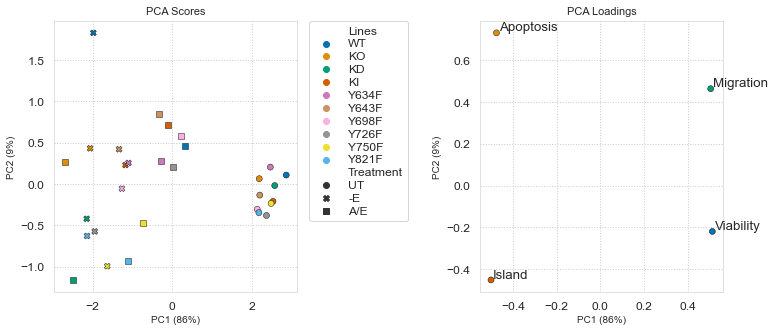

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.75, hspace=None)
plotPCA(ax, y_c, 3, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", hue_load="Phenotype", legendOut=True)

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [22]:
y = y_ae.drop("Treatment", axis=1).set_index("Lines")

# 0-. Final X and Y data sets to model

If dropping "WT", run:

In [23]:
# x = X.drop("PC9 A", axis=1)
# d = x.select_dtypes(include=['float64']).T
# i = x.select_dtypes(include=['object'])
# y = y.drop("WT")
# lines = mut_lines

In [24]:
# y = y.drop(["Migration"], axis=1)

Else:

In [25]:
lines = all_lines

# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

In [26]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p1 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p1, d, y, 1, 5)

#### Predictions

In [27]:
# fig, ax = plt.subplots(1, 4, figsize=(20,5))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# p2 = PLSRegression(n_components=2)
# plotActualVsPredicted(ax, p2, d, y, 2, y_pred="cross-validation")

In [28]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, lines, cv=1, data="full", annotate=False)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)

# 2-Clustering and PLSR model

In [29]:
ncl = 7

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [30]:
# from sklearn.cluster import KMeans

# labels = KMeans(n_clusters=ncl).fit(d.T).labels_
# x_ = X.copy()
# x_["Cluster"] = labels
# c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [31]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl).fit(d.T)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [32]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [33]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p2 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p2, c1, y, 1, ncl+1)
# # plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

In [34]:
# ig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p2, c1, y, 1, y_pred="cross-validation")
# # plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [35]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, lines, 1)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)

## 2.2-Dual data-motif clustering and regression against phenotypes

### PAM250 model

In [36]:
# distance_method = "PAM250"
# SeqWeight = 5
# ncl = 5

# MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method).fit(d, y)
# c2 = MSC.transform()

In [37]:
# MSC.wins(d)

#### Pickle selected model

In [38]:
# Pickle
# with open('AXLmodel_PAM250_W5_5CL', 'wb') as f:
#     pickle.dump([MSC], f)

# Unpickle
with open('AXLmodel_PAM250_W5_5CL', 'rb') as f:
    MSC = pickle.load(f)[0]
c2 = MSC.transform()
ncl = 5

## 2.2.1 PLSR

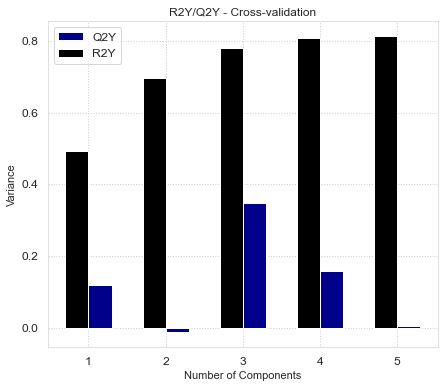

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
size = ncl + 1
if ncl > 5:
    size = 5
plotR2YQ2Y(ax, PLSRegression(n_components=3, scale=True), c2, y, size)

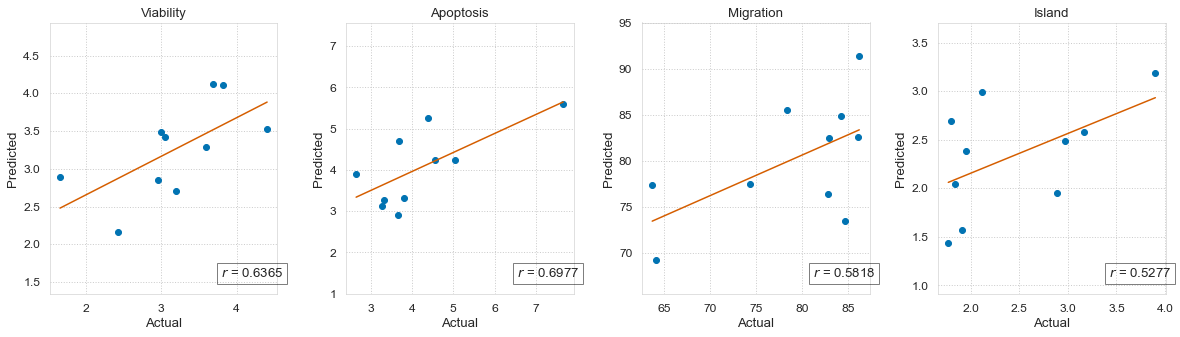

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
p3 = PLSRegression(n_components=3, scale=True)
plotActualVsPredicted(ax, p3, c2, y, y_pred="cross-validation")

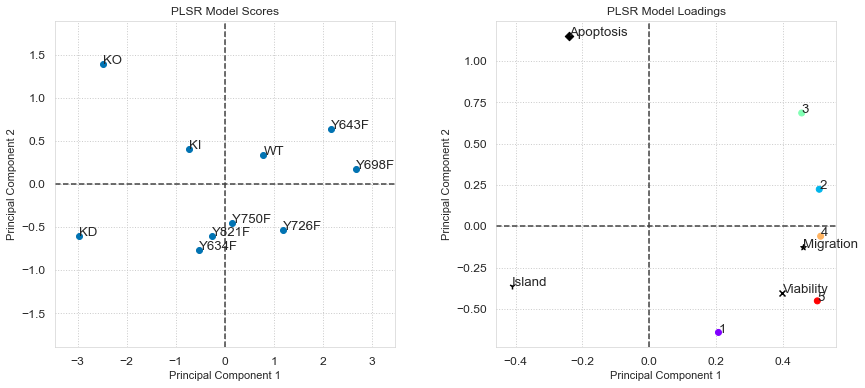

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

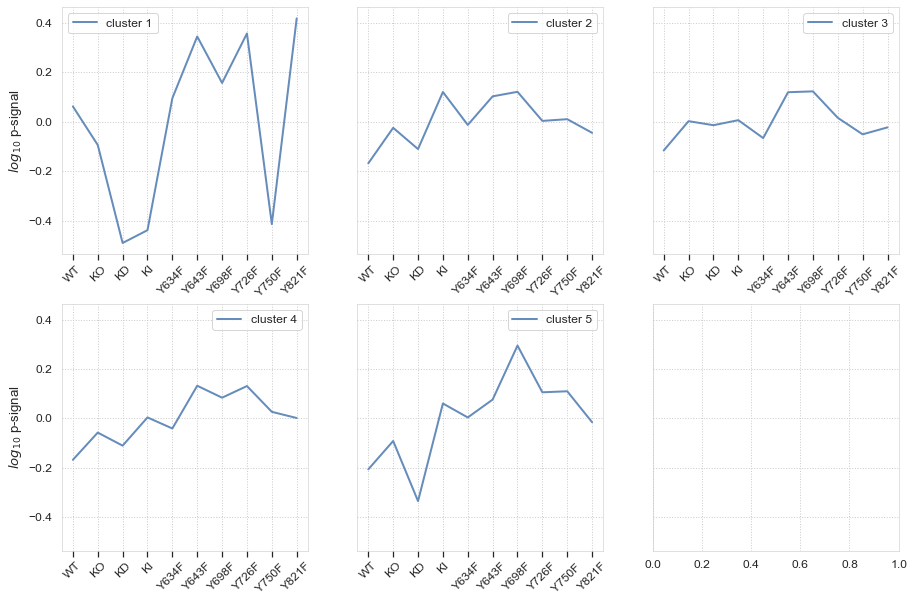

In [42]:
plotCenters(c2, 2, 3, all_lines, figsize=(15, 10))

In [43]:
pssms = MSC.pssms(X["Sequence"])

In [48]:
pssms[0]

,0,1,2,3,4,5,6,7,8,9,10
A,0.379654,0.563365,0.148328,0.674081,-0.141179,0.000000,-4.000000,-4.000000,0.443784,-0.489102,-0.588638
C,2.581287,-4.000000,-4.000000,-4.000000,-4.000000,0.000000,0.996325,-4.000000,-4.000000,-4.000000,-4.000000
D,-1.635943,-0.556216,0.411362,-0.306238,-0.556216,0.000000,1.192722,0.318253,1.318253,1.148328,1.147942
E,-0.266709,0.460272,-0.242462,-0.726141,-0.535386,0.000000,-0.306238,0.773933,1.733291,1.607753,0.773933
F,-4.000000,0.996325,1.733291,-0.141179,-4.000000,0.000000,-4.000000,-0.003675,0.996306,-4.000000,0.996325
G,0.858821,-4.000000,-0.635884,-0.556216,-1.139872,0.000000,-0.851672,-0.202181,-0.929674,-0.681747,-0.764868
H,0.148328,0.148328,-4.000000,1.147111,-4.000000,0.000000,-0.003675,1.733726,-4.000000,-4.000000,-4.000000
I,1.510898,1.004995,-4.000000,0.318253,-4.000000,0.000000,-4.000000,-4.000000,-4.000000,-0.382187,-0.074064
K,-4.000000,-1.635898,-0.141179,-0.681747,0.617813,0.000000,1.733291,-0.266709,0.148328,-0.074064,-4.000000
L,-0.074756,0.794691,0.318253,-1.205309,-1.039299,0.000000,-4.000000,-1.635943,-2.296457,-1.205309,1.081203
